In [1]:
from hydra import initialize, compose
from hydra.utils import instantiate

import numpy as np

from scipy.stats import spearmanr, kendalltau, linregress

from einops import rearrange

import torch

import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.utilities import move_data_to_device

from bliss.global_env import GlobalEnv

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
ckpt = "/data/scratch/descwl/checkpoints/encoder_wld_galaxies80_stars0.ckpt"

with initialize(config_path="../", version_base=None):
    cfg = compose("config_descwl", {
        "train.pretrained_weights=" + ckpt,
        })

seed = pl.seed_everything(cfg.train.seed)
GlobalEnv.seed_in_this_program = seed

Seed set to 123123


Configure the test dataloader:

In [3]:
data_source = instantiate(cfg.train.data_source)
data_source.setup("test")
test_dl = data_source.test_dataloader()

Load in encoder weights:

In [4]:
encoder = instantiate(cfg.encoder).to(device)
encoder_state_dict = torch.load(cfg.train.pretrained_weights, map_location=device)["state_dict"]
encoder.load_state_dict(encoder_state_dict)
encoder = encoder.eval()

Store true and posterior mode shear and convergence for the test images:

In [5]:
shear1_true = torch.zeros(len(test_dl), device=device)
shear1_pred = torch.zeros(len(test_dl), device=device)
shear2_true = torch.zeros(len(test_dl), device=device)
shear2_pred = torch.zeros(len(test_dl), device=device)
convergence_true = torch.zeros(len(test_dl), device=device)
convergence_pred = torch.zeros(len(test_dl), device=device)
test_loss = torch.zeros(len(test_dl), device = device)

i = -1
for b in test_dl:
    i += 1
    batch = move_data_to_device(b, device)
    
    shear1_true[i] = batch['tile_catalog']['shear_1'].squeeze()
    shear2_true[i] = batch['tile_catalog']['shear_2'].squeeze()
    
    with torch.no_grad():
        mode_cat = encoder.sample(batch, use_mode=True)
        test_loss[i] = encoder._compute_loss(batch, None)
    
    shear1_pred[i] = mode_cat['shear_1'].squeeze()
    shear2_pred[i] = mode_cat['shear_2'].squeeze()

/home/twhit/bliss/.venv/lib/python3.10/site-packages/pytorch_lightning/core/module.py:441: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


Compute test MSEs:

In [6]:
print(f'shear 1 test MSE (BLISS) = {((shear1_true - shear1_pred) ** 2).mean()}')
print(f'shear 2 test MSE (BLISS) = {((shear2_true - shear2_pred) ** 2).mean()}')

shear 1 test MSE (BLISS) = 3.1619393325854617e-07
shear 2 test MSE (BLISS) = 4.184023225661804e-07


Compute Pearson correlation coefficients:

In [7]:
print(f'shear 1 pearson correlation (BLISS) = {np.corrcoef(shear1_true.flatten().cpu(), shear1_pred.flatten().cpu())[1,0]}')
print(f'shear 2 pearson correlation (BLISS) = {np.corrcoef(shear2_true.flatten().cpu(), shear2_pred.flatten().cpu())[1,0]}')

shear 1 pearson correlation (BLISS) = 0.9997337178717476
shear 2 pearson correlation (BLISS) = 0.999356658192186


Compute Spearman correlation coefficients:

In [8]:
print(f'shear 1 spearman correlation (BLISS) = {spearmanr(shear1_true.flatten().cpu(), shear1_pred.flatten().cpu())[0]}')
print(f'shear 2 spearman correlation (BLISS) = {spearmanr(shear2_true.flatten().cpu(), shear2_pred.flatten().cpu())[0]}')

shear 1 spearman correlation (BLISS) = 0.9996339908497713
shear 2 spearman correlation (BLISS) = 0.9995424885622143


Compute Kendall correlation coefficients:

In [9]:
print(f'shear 1 kendall correlation (BLISS) = {kendalltau(shear1_true.flatten().cpu(), shear1_pred.flatten().cpu())[0]}')
print(f'shear 2 kendall correlation (BLISS) = {kendalltau(shear2_true.flatten().cpu(), shear2_pred.flatten().cpu())[0]}')

shear 1 kendall correlation (BLISS) = 0.9872361809045226
shear 2 kendall correlation (BLISS) = 0.9866331658291457


Compute test loss:

In [10]:
print(f'test loss = {test_loss.mean()}')

test loss = -11.61041259765625


Scatterplots of true vs. posterior mode shear and convergence:

Shear1: intercept = 0.00042, slope = 0.99905, |m| = 0.0009533227837295044
Shear2: intercept = -0.00032, slope = 0.99778, |m| = 0.0022192303351900033


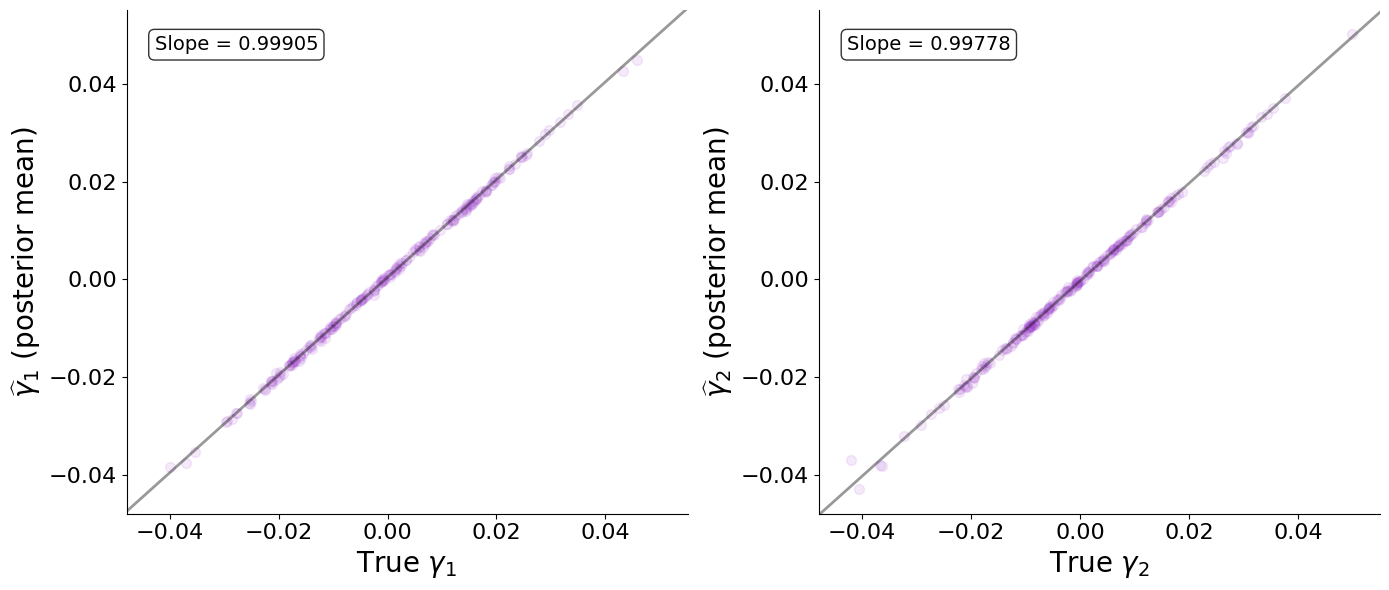

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
alpha = 0.1
s = 50
fontsize = 20
ticklabelsize = 16
bliss_color = 'darkorchid'
baseline_color = 'sienna'
axmin = min(shear1_true.min(), shear2_true.min(), shear1_pred.min(), shear2_pred.min(), convergence_true.min(), convergence_pred.min()).cpu() - 0.005
axmax = max(shear1_true.max(), shear2_true.max(), shear1_pred.max(), shear2_pred.max(), convergence_true.quantile(0.995), convergence_pred.quantile(0.995)).cpu() + 0.005

slope1, intercept1, r_value1, p_value1, std_err1 = linregress(shear1_true.flatten().cpu().numpy(), shear1_pred.flatten().cpu().numpy())
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(shear2_true.flatten().cpu().numpy(), shear2_pred.flatten().cpu().numpy())

_ = ax[0].scatter(shear1_true.flatten().cpu().numpy(),
                  shear1_pred.flatten().cpu().numpy(),
                  color=bliss_color, alpha=alpha, s=s, zorder=1)
x_line = np.linspace(axmin, axmax, 100)
y_line1 = slope1 * x_line + intercept1
ax[0].plot(x_line, y_line1, color='black', linewidth=2, alpha=0.4, zorder=2)
ax[0].text(0.05, 0.95, f'Slope = {slope1:.5f}', 
           transform=ax[0].transAxes, fontsize=14, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

_ = ax[0].set_xlabel(r'True $\gamma_1$', fontsize=fontsize)
_ = ax[0].set_ylabel(r'$\widehat{\gamma}_1$ (posterior mean)', fontsize=fontsize)
_ = ax[0].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[0].set_xlim((axmin, axmax))
_ = ax[0].set_ylim((axmin, axmax))

# Plot shear2
_ = ax[1].scatter(shear2_true.flatten().cpu().numpy(),
                  shear2_pred.flatten().cpu().numpy(),
                  color=bliss_color, alpha=alpha, s=s, zorder=1)
y_line2 = slope2 * x_line + intercept2
ax[1].plot(x_line, y_line2, color='black', linewidth=2, alpha=0.4, zorder=2)
ax[1].text(0.05, 0.95, f'Slope = {slope2:.5f}', 
           transform=ax[1].transAxes, fontsize=14, verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

_ = ax[1].set_xlabel(r'True $\gamma_2$', fontsize=fontsize)
_ = ax[1].set_ylabel(r'$\widehat{\gamma}_2$ (posterior mean)', fontsize=fontsize)
_ = ax[1].tick_params(axis='both', which='major', labelsize=ticklabelsize)
_ = ax[1].set_xlim((axmin, axmax))
_ = ax[1].set_ylim((axmin, axmax))

for a in ax.flat:
    _ = a.spines[['top', 'right']].set_visible(False)

fig.tight_layout()
fig.savefig("figures/scatterplots.png", dpi=300, transparent=True, bbox_inches='tight', pad_inches=0)

# Print regression statistics
print(f"Shear1: intercept = {intercept1:.5f}, slope = {slope1:.5f}, |m| = {np.abs(slope1 - 1)}")
print(f"Shear2: intercept = {intercept2:.5f}, slope = {slope2:.5f}, |m| = {np.abs(slope2 - 1)}")